# Introducción: Modelo Mixto para Clasificar y Predecir calidad y tipo de vino

En este proyecto vamos a realizar un modelo que pueda pronosticar la calidad de un vino calificáncolo del 1 al 10 y clasificando si el vino corresponde al tipo de vino blanco o rojo.
Para esta tarea necesitaremos crear un modelo que tome las características de los products y nos de como resultado dos outputs.
En este caso utilizaremos un modelo funcional personalizado para lograr resolver la tarea esperada.

Estos son los pasos a seguir para completar la tarea:

1. Importar librerías para la creación del modelo.
2. Limpia y transformación de datos.
3. Creación y normalización de datasets.
4. Construcción del modelo y compilación.
5. Entrenamiento del modelo, validación de presición y métricas de error.

# 1. Importación de librerías

Para esta tarea utilizaremos un modelo personalizado utilizando la librería TensorFlow.
También necesitaremos librerías para visualizar nuestra data y validar resultados de entrenamiento.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools
from sklearn.utils import shuffle

# 2. Limpia y transformación de datos

Vamos a utilizar una base de datos gratuita encontrada en UCI Machine Learning Repository.
Esta base de datos contiene características de vinos blancos y rojos.
Debemos cargar las bases de datos de vinos blancos y rojos por separado y agregar una columna que indique que tipo de vino es según la base de datos.

In [2]:
URI = './winequality-white.csv'
white_df = pd.read_csv(URI, sep=";")
white_df["is_red"] = 0
white_df = white_df.drop_duplicates(keep='first')

In [3]:
URI = './winequality-red.csv'
red_df = pd.read_csv(URI, sep=";")
red_df["is_red"] = 1
red_df = red_df.drop_duplicates(keep='first')

In [4]:
# Concatenamos las bases de datos para unir toda la data
df = pd.concat([red_df, white_df], ignore_index=True)

In [5]:
# Mezclamos la data al azar para entrenar el modelo de manera más eficiente
df = df.iloc[np.random.permutation(len(df))]

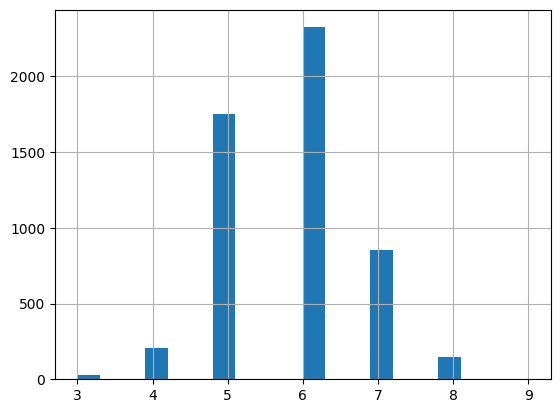

In [6]:
# Revisamos la disperción de calidad del modelo
df['quality'].hist(bins=20);

Podemos observar que tenemos un gran desbalance de clases, vamos a realizar el método bootstrapping para tener más información sobre las clases raras.
De esta manera podremos entrenar el modelo de manera más eficiente.

In [ ]:
# Definimos función para que la clase rara se vuelva más relevante
def up_sample(df, n1, n2, n3, n4, repeat):
    df_repeat = df[df['quality'].isin([n1, n2, n3, n4])]

    df_repeat = df_repeat.sample(n=repeat * len(df_repeat), replace=True, random_state=12345)

    df_up = pd.concat([df, df_repeat], axis=0).reset_index(drop=True)

    df_up = shuffle(df_up, random_state=12345)

    return df_up

In [10]:
df_up = up_sample(df, 3, 4, 8, 9, 4)

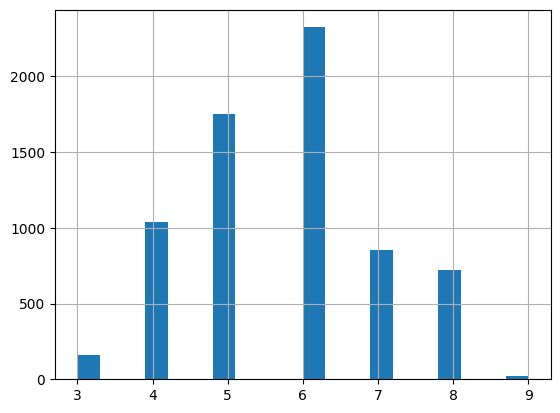

In [11]:
df_up['quality'].hist(bins=20);

Como podemos observar subieron la cantidad de datos que tenemos por clase rara.
En este caso los vinos con calidad 3 y 9 siguen siendo bastante raros, así que el modelo se podrías sesgar a calificar los vinos con valores intermedios a estos.

# 3. Creación y normalización de data sets.

En esta sección vamos a crear nuestros datasets para entrenar, validar y probar nuestro modelo.
También vamos a normalizar la data de tal manera que todo sea escalado usando la desviación estándar y el promedio de los datos.
La escalamos de tal manera qye se normalice en un intervalo de 0 y 1.

In [ ]:
# Creamos nuestros datasets para el modelo
train, test = train_test_split(df_up, test_size=0.20, random_state = 1)
train, val = train_test_split(train, test_size=0.20, random_state = 1)

In [13]:
train_stats = train.describe()
train_stats.pop('is_red')
train_stats.pop('quality')
train_stats = train_stats.transpose()

In [14]:
train_stats

,count,mean,std,min,25%,50%,75%,max
fixed acidity,4400.0,7.200125,1.300526,3.80000,6.40000,7.0000,7.7000,15.60000
volatile acidity,4400.0,0.357019,0.181937,0.08000,0.23875,0.3000,0.4300,1.58000
citric acid,4400.0,0.315695,0.148334,0.00000,0.24000,0.3100,0.4000,1.00000
residual sugar,4400.0,4.924739,4.409930,0.70000,1.70000,2.7000,7.1000,65.80000
chlorides,4400.0,0.055601,0.035616,0.01200,0.03700,0.0470,0.0650,0.61000
free sulfur dioxide,4400.0,29.479091,20.216076,1.00000,15.00000,27.0000,40.0000,289.00000
total sulfur dioxide,4400.0,113.352159,58.531048,6.00000,73.00000,114.0000,154.0000,440.00000
density,4400.0,0.994339,0.003009,0.98713,0.99198,0.9944,0.9966,1.03898
pH,4400.0,3.227125,0.163334,2.72000,3.11000,3.2200,3.3300,3.90000
sulphates,4400.0,0.525420,0.151039,0.22000,0.43000,0.5000,0.6000,2.00000


Como podemos observar aqui exploramos la data de entrenamiento.
Vemos uns descripción de nuestra data para sacar los promedios y desviación estandar que se van a utilizar para nuestra normalización.

In [ ]:
# Definimos una fórmula para crear los "labels" u objetivos de entrenamiento
def format_output(data):
    is_red = data.pop('is_red')
    is_red = np.array(is_red)
    quality = data.pop('quality')
    quality = np.array(quality)
    return (quality, is_red)

In [16]:
train_Y = format_output(train)

val_Y = format_output(val)
    
test_Y = format_output(test)

Al utilizar nuestra fórmula para crear los labels podemos observar que las columnas objetivo ya no se encuentran dentro de nuestro dataset de entrenamiento.
Esto pasa de la misma forma para el resto de los datasets.

In [17]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
878,7.1,0.26,0.19,8.2,0.051,53.0,187.0,0.99600,3.16,0.52,9.7
3899,9.2,0.59,0.24,3.3,0.101,20.0,47.0,0.99880,3.26,0.67,9.6
3134,6.6,0.27,0.52,8.1,0.044,53.0,202.0,0.99548,3.18,0.48,9.5
4789,7.1,0.30,0.49,1.6,0.045,31.0,100.0,0.99420,3.40,0.59,10.2
6618,6.0,0.59,0.00,0.8,0.037,30.0,95.0,0.99032,3.10,0.40,10.9


## 3.1 Normalización de la data

Es muy importante normalizar la data ya que esto hace más sencillo el entrenamiento del modelo. El resultado nos deja un set de data que le resulta al modelo más sencillo de procesar.
Para normalizar la data vamos a restar el promedio de nuestras características a el valor total de las características y dividirlo por su desviación estándar.

Al restar el promedio estamos centrando la data a un valor más cercano al 0 y al dividirla por la desviación estándar estamos normalizando la información.

$$x_{norm} = \frac{x - \mu}{\sigma}$$

In [18]:
# Definimos fórmula para normalizar datasets
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [20]:
norm_train_X = norm(train)
    
norm_val_X = norm(val)
    
norm_test_X = norm(test)

# 4. Construcción del modelo y compilación

En esta sección vamos a construir la base de nuestro modelo, especificando las capas de entrenamiento, los inputs, el resultado que esperamos y lo vamos a compilar con mñetricas de error y validación.

In [21]:
# Definimos una fórmula que contenga la base de nuestro modelo, capa capa tendrá una capa de neuronas de 128 unidad y una activación relu.
def base_model(inputs):
    x = Dense(units=128, activation='relu')(inputs)
    x = Dense(units=128, activation='relu')(x)
    return x

## 4.1 Definición del output

Este modelo tendrá dos capas de output, una de calidad y una de tipo. Ya que son dos outputs distintos necesitaremos que uno nos ayude con una regresión y el otro con la clasificación del modelo.

Dejamos la última capa con una neurona que definirá el resultado de nuestro objetivo.

Una de las capas será usada pata la regresión de la calidad del vino.

La otra capa será de clarificación del tipo de vino, usamos una activación sigmoide para ayudar a clasificar el tipo de vino usando probabilidad.

In [25]:
# Definimos fórmula para crear nuestro modelo final
def final_model(inputs):
    x = base_model(inputs)
    wine_quality = Dense(units=1, name='wine_quality')(x)
    wine_type = Dense(units=1, activation='sigmoid', name='wine_type')(x)
    model = Model(inputs=inputs, outputs=[wine_quality, wine_type])
    return model

## 4.2 Compilación del modelo.

Ahora es tiempo de compilar nuestro modelo, en esta sección vamos a agregar las métricas de error, de validación de precisión y un optimizador de descenso de gradiante.

- Creamos la capa de input para darle forma al modelo.
- Utilizamos RMSprop como optimizador usando retropropagación para ajustar pesos de las neuronas y calculando el error capa por capa.
- Como métrica de error para tipo de vino usamos binary_correntropy el cual mide la distancia entre la predicción y el objetivo real; para calidad usaremos el promedio cuadrado de desviación MSE.
- Como metricas de precición para tipo de vino usaremos binary_accurancy saca la proporción de predicciones positivas contra negativas, para calidad usaremos la raíz cuadrar del promedio cuadrado de desviación para medir que tan lejos están las predicciones de la realidad.

In [26]:
inputs = tf.keras.layers.Input(shape=(11,))
rms = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model = final_model(inputs)

model.compile(optimizer=rms, 
               loss = {'wine_type' : 'binary_crossentropy',
                       'wine_quality' : 'mse'
                      },
               metrics = {'wine_type' : 'binary_accuracy',
                          'wine_quality': tf.keras.metrics.RootMeanSquaredError()
                        }
              )

# 5. Entrenamiento del modelo, validación y visualización

Ya que tenemos nuestro model construido y compilado ya podemos entrenarlo y medir que tan bueno es su funcionamiento.
En esta seccion prepararemos gráficas que nos ayuden a visualizar como se comporta el modelo al ser entrenado.

In [27]:
history = model.fit(norm_train_X, train_Y, epochs = 40, validation_data=(norm_val_X, val_Y))

Epoch 1/40
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 26.1893 - wine_quality_loss: 25.4743 - wine_quality_root_mean_squared_error: 5.0398 - wine_type_binary_accuracy: 0.4520 - wine_type_loss: 0.7145 - val_loss: 12.7923 - val_wine_quality_loss: 12.1546 - val_wine_quality_root_mean_squared_error: 3.4781 - val_wine_type_binary_accuracy: 0.5018 - val_wine_type_loss: 0.6955
Epoch 2/40
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.1898 - wine_quality_loss: 9.5123 - wine_quality_root_mean_squared_error: 3.0762 - wine_type_binary_accuracy: 0.5949 - wine_type_loss: 0.6773 - val_loss: 4.8746 - val_wine_quality_loss: 4.3743 - val_wine_quality_root_mean_squared_error: 2.0703 - val_wine_type_binary_accuracy: 0.8055 - val_wine_type_loss: 0.5886
Epoch 3/40
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6952 - wine_quality_loss: 4.1540 - wine_quality_root_mean_squared_error: 2.0371 - wine_type_binary_accuracy: 0.8025 - wine_type_loss: 0.5410 - val_loss: 3.5060 - val_wine_quality_loss: 

In [28]:
# Evaluemos el modelo utilizando las métricas definias de error y precisión
loss, wine_quality_loss, wine_type_loss, wine_quality_rmse, wine_type_accuracy = model.evaluate(x=norm_val_X, y=val_Y)

print()
print(f'loss: {loss}')
print(f'wine_quality_loss: {wine_quality_loss}')
print(f'wine_type_loss: {wine_type_loss}')
print(f'wine_quality_rmse: {wine_quality_rmse}')
print(f'wine_type_accuracy: {wine_type_accuracy}')


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8015 - wine_quality_loss: 0.7673 - wine_quality_root_mean_squared_error: 0.8751 - wine_type_binary_accuracy: 0.9951 - wine_type_loss: 0.0349

loss: 0.8214722871780396
wine_quality_loss: 0.800775945186615
wine_type_loss: 0.032298743724823
wine_quality_rmse: 0.8881054520606995
wine_type_accuracy: 0.9945454597473145


Nuestro modelo logra clasificar con mayor precisión el tipo de vino que su calidad.
Esto se debe a que tenermos poco datos sobre vinos de calidad 3 y 9 que generan ruido y afectan su entrenamiento.

## 5.1 Analizar comportamiento

Veamos con más detalle cómo está funcionando nuestras predicciones.
Visualizaremos nuestras métricas de error y veremos que tan efectivas son las predicciones del modelo.

In [29]:
predictions = model.predict(norm_test_X)
quality_pred = predictions[0]
type_pred = predictions[1]

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [ ]:
# Definimos fórmula para crear una gráfica lineal del cualquiera de nuestras métricas
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


In [ ]:
# Definimos fórmula para crear una matrix de confución entre los objetivos reales y las predicciones
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(test_Y[1], np.round(type_pred), labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0, 1])
    disp.plot(values_format='d');

In [ ]:
# Definimos fórmula para crear un gráfico de deiperción entre objetivos reales y predicciones del modelo
def plot_diff(y_true, y_pred, title = '' ):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.plot([-100, 100], [-100, 100])
    return plt

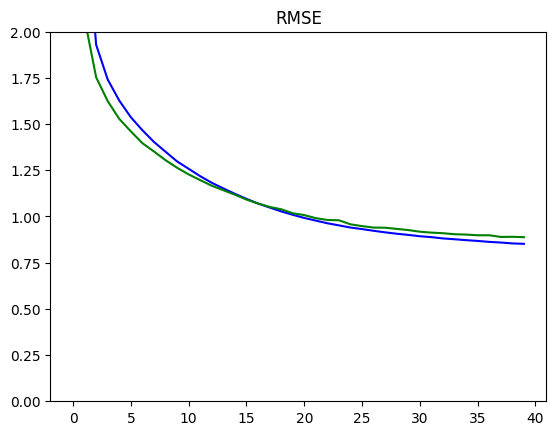

In [35]:
plot_metrics('wine_quality_root_mean_squared_error', 'RMSE', ylim=2)

En esta primera gráfica podemos observar como entrena el modelo e itera sobre el error RMSE de la calidad del modelo.
Podemos observar que la los datastes de entrenamiento(azul) y de validación(verde), entrenan de manera similar, teniendo un descenso cercano a 1.
Esto significa que hay una desviación de calidad de 1 punto al realizar la predicción, lo cual causa ruido ya que es 1 categorñia de calidad dentro de la desviación.

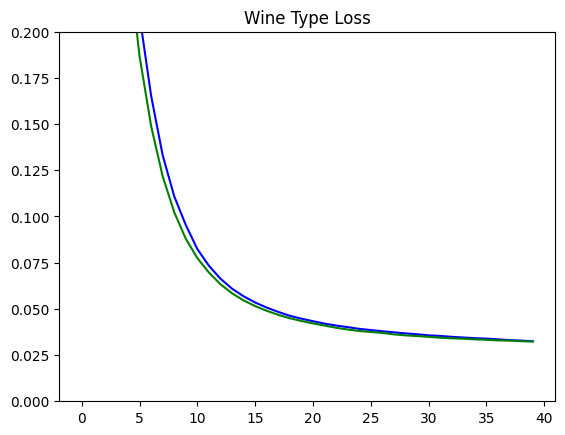

In [36]:
plot_metrics('wine_type_loss', 'Wine Type Loss', ylim=0.2)

En esta gráfica vemos el error dentro de la calificación pr tipo de vino.
El data set de entrenamiento(azul) y el de validación(verde) iteran de manera similar llegando a un error promedio de 0.3
Esta desviación nos indicción nos indica que tenemos un pequeño error al predecir el tipo de vino.

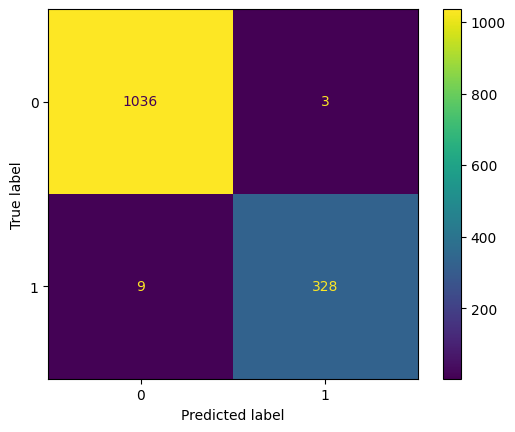

In [37]:
plot_confusion_matrix(test_Y[1], np.round(type_pred), title='Wine Type', labels = [0, 1])

Usamos una matrix de confusión para ver que tan buena es nuestra clasificación por tipo.
Esto nos ayuda a visualizar los verdaderos positivos contra los falsos positivos.
Podemos ver que en la gram mayoría de los casos la clasificación es efectiva, con sólo 12 casos entro del modelo teniendo información errónea.

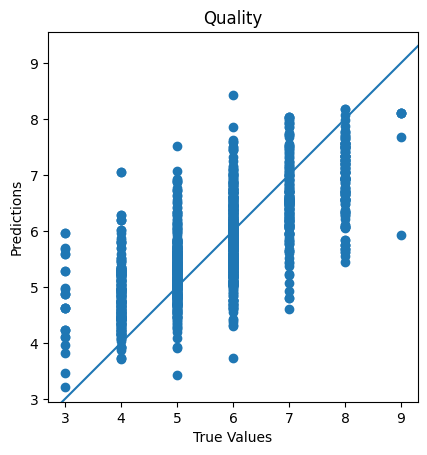

In [39]:
scatter_plot = plot_diff(test_Y[0], quality_pred, title='Quality')

En esta gráfica de disperción podemos observar el contraste de la predicción positiva contra los objetivos reales.
Al tener poca información de calidad de vinos de la categoría 3 y 9 causa más ruido dentro de nuestra prediccón.
Podemos observar que en las categorías 3 y 9 las predicciones en la mayoría de los casos no son efectivas.
Esto nos puede indicar que estas categorías están afectando la predicción del modelo y su precisión en clasificar por categoría.

# 6. Conclusiones

En este proyecto contruimos un modelo de predicción para tipo y calidad de vinos.
En donde creamos un modelo personalizado que nos diera dos outputs como resultado.

Al tratar la data nos dimos cuenta que teniamos pocas observaciones de vinos para las categorías 3, 4, 8 y 9.
Por lo cual usamos la técnica de bootstrapping para aumentar las observaciones de las categorías raras.

Estos nos resulto efectivo para las categorías 4 y 8, para las categorías 3 y 9 no fue suficiente.

Quisimos entrenar el modelo con la data disponible para no discriminar categorías dentro del modelo, y esto resultó afectar las predicciones y precisión del modelo.

En un caso real, recomendaría no usar las categorías 3 y 9 para el entrenamiento del modelo o en su caso conseguir más observaciones de estas categorías para el modelo.
También crearía modelo que excluyan estas categorías y presentar las diferencias de entrenamiento.

Este proyecto sirve para demostrar el uso de un modelo pèrsonalizado que tengas como resultados dos outputs distintos.